<a href="https://colab.research.google.com/github/junfeiai/Convex_OPF/blob/main/linear_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.io import loadmat
import numpy as np
import math
import tensorflow as tf
import matplotlib

In [27]:
'''
#This is the block to load data from matlab, and cvs dataset
#Then process them ready for the neural network training
'''
#Load grid data from matlab
mat_y = loadmat('/content/drive/MyDrive/Phd/icnn_gan/Y_bus14.mat')
mat_gen = loadmat('/content/drive/MyDrive/Phd/icnn_gan/IEEE14_gen.mat')['gen118']
#mat_load = loadmat('/content/drive/MyDrive/Phd/opf_gan/IEEE118_load.mat')
#mat_gencost = pd.read_csv('new_cost.csv').values[:,1:]
#mat_gencost = loadmat('/content/drive/MyDrive/Phd/opf_gan/case118_gencost.mat')['gencost']
#line_constraints = loadmat('/content/drive/MyDrive/Phd/opf_gan/grid118_line_constraints.mat')['line_constraint']

#Load dataset
conditions = loadmat('/content/drive/MyDrive/Phd/icnn_gan/grid_14_demand.mat')['conditions_list']
solutions = loadmat('/content/drive/MyDrive/Phd/icnn_gan/grid_14_solution.mat')['datapoints_list']

Y_bus = mat_y['Y_bus14'].astype('complex64')

grid_size = 14
baseMVA = 100
gen_size = 5

In [29]:
def disassemble_mp_structure(condition,solution):
    demand_p = condition[:,0:grid_size]/baseMVA
    demand_q = condition[:,grid_size:grid_size*2]/baseMVA
    vm = solution[:,0:grid_size]
    va = solution[:,grid_size:grid_size*2]

    matpower_p = solution[:,grid_size*2:grid_size*2+gen_size]
    matpower_q = solution[:,grid_size*2+gen_size:]
    p = np.zeros(vm.shape)
    q = np.zeros(va.shape)
    gen_ids = mat_gen[:,0]-1
    j=0
    gen_pos = np.zeros(grid_size)
    for i in range(0,grid_size):
      if i in gen_ids:
        p[:,i]=matpower_p[:,j]
        q[:,i]=matpower_q[:,j]
        j=j+1
        gen_pos[i]=1
    p=p/baseMVA
    q=q/baseMVA
    #gen_pos_tf = tf.convert_to_tensor(gen_pos,dtype='float32')
    gen_pos = gen_pos
    return demand_p,demand_q,vm,va,p,q

In [30]:
demand_p,demand_q,vm,phi,p,q = disassemble_mp_structure(conditions,solutions)
v_r = tf.math.multiply(vm,tf.cos(tf.math.multiply(phi,tf.constant(math.pi/180,dtype='float32'))))
v_i = tf.math.multiply(vm,tf.sin(tf.math.multiply(phi,tf.constant(math.pi/180,dtype='float32'))))
V = tf.complex(v_r,v_i)
#calculate current
Y_bus_tf = tf.convert_to_tensor(Y_bus)

In [35]:
def get_g1(index):
  g1 = tf.reshape(V[index,0],[-1,1])*tf.reshape(np.conj(Y_bus_tf[0,:]),[1,118])
  g1 = g1.numpy()
  g1[:,0]=V[index,0]*np.conj(Y_bus_tf[0,0])+tf.math.reduce_mean(tf.reshape(np.conj(V[index,:]),[-1,1])*np.conj(Y_bus_tf[0,:]))
  return g1

def get_gi(s_i,n_i):
  #s_i is index of buses; n_i is index of data point in dataset
  gi = tf.reshape(V[n_i,s_i],[-1,1])*tf.reshape(np.conj(Y_bus_tf[s_i,:]),[1,grid_size])
  gi = gi.numpy()
  gi[:,s_i]=V[n_i,s_i]*np.conj(Y_bus_tf[s_i,s_i])+tf.math.reduce_mean(tf.reshape(np.conj(V[n_i,:]),[-1,1])*np.conj(Y_bus_tf[s_i,:]))
  return gi

In [ ]:
"""g1 = tf.reshape(V[1:3,0],[-1,1])*tf.reshape(Y_bus_tf[0,:],[1,118])
g1 = g1.numpy()
g1[:,0]=V[1:3,0]*Y_bus_tf[0,0]+tf.math.reduce_mean(tf.reshape(V[1:3,:],[-1,1])*Y_bus_tf[0,:])"""

In [36]:
ll = []
for s_i in range(0,grid_size):
  for i in range(0,1000):
    ram = np.random.randint(0,5000,2)
    U = get_gi(s_i,ram[0]).flatten()
    #ram = np.random.randint(0,240000,1)
    K = get_gi(s_i,ram[1]).flatten()
    diff = np.real(np.sum(np.conj(K)*U))/(np.sqrt(abs(np.sum(U*np.conj(U))))*np.sqrt(abs(np.sum(K*np.conj(K)))))
    ll.append(diff)
    print(diff)

Streaming output truncated to the last 5000 lines.
0.99885035
0.99627465
0.99196994
0.989252
0.9976893
0.99988633
0.9997854
0.9975777
0.9999229
0.94838023
0.99723893
0.99613005
0.99864596
0.9999736
0.98915184
0.9999758
0.9977578
0.99820703
0.99649763
0.99931854
0.999956
0.9948777
0.9958729
0.9984873
0.97420615
0.9952259
0.99958736
0.998827
0.9802442
0.9843686
0.9989501
0.9968193
0.99859655
0.99356616
0.9999602
0.9696376
0.9823552
0.9921938
0.9997482
0.993624
0.99772847
0.9989333
0.9995418
0.9848721
0.9969949
0.99845743
0.99990237
0.98331237
0.9987975
0.9994417
0.9953751
0.9998639
0.9982711
0.9993451
0.9999794
0.9994451
0.99468297
0.98304313
0.9983087
0.9977723
0.9702985
0.99003625
0.9995285
0.9965404
0.99946725
0.99038315
0.9960149
0.98932076
0.99992824
0.99861354
0.9992534
0.997958
0.9980407
0.9808082
0.9939384
0.99543095
0.99639904
0.9963766
0.999321
0.99861896
0.99536103
0.999987
0.99574316
0.99996346
0.9871732
0.9969405
0.9997825
0.99391556
0.99653965
0.99847096
0.99473584
0.994812

In [38]:
np.mean(np.array(ll))

0.99506485

Text(0.5, 1.0, 'Histogram of pair gradient similarity for all buses')

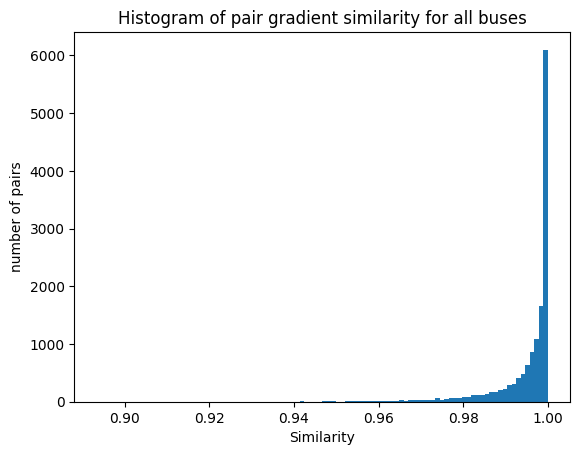

In [39]:
from matplotlib import pyplot as plt
plt.hist(np.array(ll),bins=100)
plt.xlabel('Similarity')
plt.ylabel('number of pairs')
plt.title('Histogram of pair gradient similarity for all buses')